# Using Gensim

In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import BrownCorpus
import nltk

def print_most_similar(model, word):
    print(f"{word}: {', '.join([f'{w} {p:0.3f}' for w, p in model.wv.most_similar(word, topn=6)])}")
    # print(f"{word}: {', '.join([f'{w} {p:0.3f}' for w, p in model.wv.most_similar_cosmul(word, topn=6)])}")

print('DOWNLOADING...')
nltk.download('brown')
sentences = nltk.corpus.brown.sents()

print('TRAINING...')
model = Word2Vec(
    sentences,
    vector_size=100, window=5, min_count=1, workers=4)

print('RESULTS...')
for w in ['king', 'sky', 'under']:
    print_most_similar(model, w)

DOWNLOADING...
TRAINING...


[nltk_data] Downloading package brown to /home/msid/nltk_data...
[nltk_data]   Package brown is already up-to-date!


RESULTS...
king: Yankee 0.966, Model 0.966, former 0.966, mood 0.965, Prince 0.965, Red 0.964
sky: gate 0.971, counter 0.967, plane 0.967, air 0.963, sun 0.963, seat 0.960
under: within 0.929, against 0.916, above 0.899, With 0.899, throughout 0.896, inhabitants 0.882


# Using Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

torch.manual_seed(1)

word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


In [2]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 8
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 32

nltk.download('gutenberg')
corpus = nltk.corpus.gutenberg.raw('bible-kjv.txt').lower().split()
print(corpus[:10])

vocab = set(corpus)
word_to_ix = {w: i for i, w in enumerate(vocab)}
ngrams = [
    (
        [corpus[i - j - 1] for j in range(CONTEXT_SIZE)],
        corpus[i]
    )
    for i in range(CONTEXT_SIZE, len(corpus))
]
print(f"NGRAM_COUNT={len(ngrams)}")
print(ngrams[:5])

class NGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeds = nn.Embedding(vocab_size, embedding_dim)
        self.layer1 = nn.Linear(
            embedding_dim * context_size,
            embedding_dim)

    def forward(self, input):
        input = self.embeds(input).flatten(1)
        output = self.layer1(input)
        output = F.log_softmax(output, dim=1)
        return output

losses = []
loss_fn = nn.MSELoss()
model = NGram(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    batch = random.sample(ngrams, BATCH_SIZE)
    input = torch.tensor([[word_to_ix[w] for w in c] for c, _ in batch], dtype=torch.long)
    expected = model.embeds(torch.tensor([word_to_ix[t] for _, t in batch], dtype=torch.long))

    pred = model(input)
    loss = loss_fn(pred, expected)

    loss.backward()
    optimizer.step()
    model.zero_grad()
    print(loss.item())

def print_similarity(w1, w2):
    w1 = model.embeds.weight[word_to_ix[w1]]
    w2 = model.embeds.weight[word_to_ix[w2]]
    print(nn.CosineSimilarity(dim=0)(w1, w2).item())

print("DONE")
print_similarity("good", "great")
print_similarity("good", "bad")

NameError: name 'nltk' is not defined

# Using Collaborative Filtering

In [ ]:
import torch, nltk, re, random
from fastai.collab import *
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [ ]:
nltk.download('gutenberg')

def corpus_to_list(corpus, context_size=2):
    words = set(corpus)

    data_dict = defaultdict(lambda: 0)
    for i, w in enumerate(corpus):
        if i < context_size or i >= len(corpus) - context_size:
            continue
        context = corpus[i-context_size : i] + corpus[i+1 : i+context_size+1]
        for c in context:
            data_dict[(w, c)] = 1
    count_pos = len(data_dict)

    for w1 in tqdm(words):
        for w2 in random.sample(words, count_pos // len(words)):
                if (w1, w2) not in data_dict and\
                        (w2, w1) not in data_dict:
                    data_dict[(w1, w2)] = -1
    print(f"corpus: {len(corpus)}")
    print(f"+ve: {count_pos}")
    print(f"all: {len(data_dict)}")
    return pd.DataFrame([{'user': k[0], 'item': k[1], 'rating': v} for k, v in data_dict.items()])

corpus = re.sub(r'[^\w]', ' ', nltk.corpus.gutenberg.raw('bible-kjv.txt')).lower().split()
# corpus = corpus[:len(corpus) // 2]
train = corpus_to_list(corpus[:len(corpus) // 2])
valid = corpus_to_list(corpus[len(corpus) // 2:])

[nltk_data] Downloading package gutenberg to /home/msid/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
  0%|          | 0/8953 [00:00<?, ?it/s]/tmp/ipykernel_12690/3436177129.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for w2 in random.sample(words, count_pos // len(words)):
100%|██████████| 8953/8953 [00:02<00:00, 4381.04it/s]


corpus: 427023
+ve: 342804
all: 680943


100%|██████████| 9016/9016 [00:02<00:00, 4347.28it/s]


corpus: 427023
+ve: 396968
all: 790818


In [ ]:
dls = CollabDataLoaders.from_df(train, bs=1024, y_range=(-1.1, 1.1))
dls.show_batch()

learn = collab_learner(dls, n_factors=8)
learn.lr_find()

ValueError: This DataLoader does not contain any batches

In [ ]:
learn.fit_one_cycle(5, 1e-1, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.871956,1.099968,00:08
1,0.767426,0.761778,00:08
2,0.458917,0.482709,00:08
3,0.249358,0.337508,00:07
4,0.195135,0.306554,00:07


In [ ]:
for ws in [('heaven', 'hell'), ('hell', 'fire')]:
    vs = [learn.model.u_weight.weight[learn.classes['user'].o2i[q]] for q in ws]
    similarity = torch.nn.functional.cosine_similarity(vs[0], vs[1], dim=-1)
    print(f"{ws} = {similarity.item()}")
print()

for q in ['evil', 'good', 'god', 'earth', 'heaven']:
    q_vec = learn.model.u_weight.weight[learn.classes['user'].o2i[q]]
    similarity = torch.nn.functional.cosine_similarity(
        q_vec, learn.model.u_weight.weight, dim=-1)
    top = similarity.argsort(descending=True)[:8]
    print(', '.join([learn.model.classes['user'][i] for i in top]))

('heaven', 'hell') = -0.040809765458106995
('hell', 'fire') = -0.045619815587997437

evil, jerusalem, shimon, stones, themselves, sent, jaazer, say
good, land, where, those, sheal, zibia, timnathheres, jokdeam
god, ye, 3, 23, men, thy, him, but
earth, see, spring, blood, ruddy, jacob, reigned, whether
heaven, tiria, pedahel, shilshah, ground, accomplish, temeni, still


# Using fastai

In [20]:
import torch, nltk, re, random, fastai
import fastai.torch_core
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import re

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

def corpus_to_list(word2idx, corpus, context_size=2):
    words = list(word2idx.keys())
    res = []
    for i, w in tqdm(enumerate(corpus)):
        if i < context_size or i >= len(corpus) - context_size:
            continue
        context = corpus[i-context_size : i] + corpus[i+1 : i+context_size+1]
        for c in context:
            res.append((word2idx[w], word2idx[c], 1))
        for _ in range(context_size * 2):
            ridx = random.randint(0, len(word2idx) - 1)
            nc = words[ridx]
            if nc not in context:
                res.append((word2idx[w], word2idx[nc], -1))
    return res

def corpus_from_file(path):
    with open(path, 'r') as file:
        text = file.read()
    text = re.sub(r'[^\w]', ' ', text.replace('<unk>', '')).lower().split()
    return text[:len(text) // 50]
    # return text

# nltk.download('gutenberg')
# corpus = re.sub(r'[^\w]', ' ', nltk.corpus.gutenberg.raw('bible-kjv.txt')).lower().split()
# corpus = corpus[:50000]

# corpus = corpus_from_file('datasets/wikitext2/train.csv'), corpus_from_file('datasets/wikitext2/test.csv')

corpus = 'x x bad x terrible x x y y good y y'.split(), 'y y good y y x bad x x terrible x x'.split()

word2idx = {w: i for i, w in enumerate(set(corpus[0]).union(set(corpus[1])))}
idx2word = {i: w for w, i in word2idx.items()}
print(f"#words = {len(word2idx)}")
train = corpus_to_list(word2idx, corpus[0])
valid = corpus_to_list(word2idx, corpus[1])

print(f"#TRAIN {len(train)}, #VALID {len(valid)}")
train[:10]

True
NVIDIA GeForce RTX 3070 Laptop GPU
#words = 5


12it [00:00, 80401.99it/s]
12it [00:00, 67559.26it/s]

#TRAIN 53, #VALID 44


[(3, 2, 1),
 (3, 2, 1),
 (3, 2, 1),
 (3, 1, 1),
 (3, 0, -1),
 (3, 0, -1),
 (3, 0, -1),
 (2, 2, 1),
 (2, 3, 1),
 (2, 1, 1)]

SuggestedLRs(valley=0.02754228748381138)

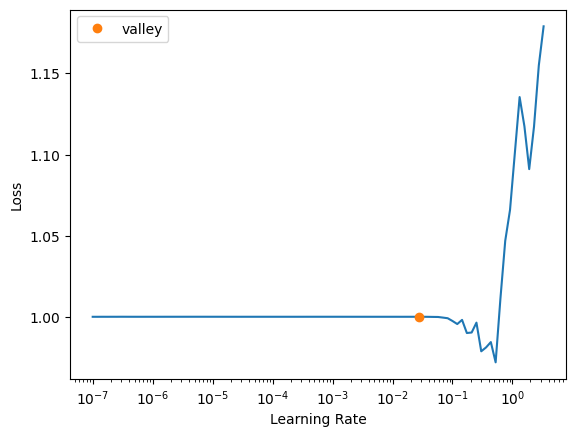

In [21]:
from fastai.data.core import DataLoaders

class WordEmbed(fastai.torch_core.Module):
    def __init__(self, n_words, dims):
        self.center = fastai.layers.Embedding(n_words, dims)
        self.context = fastai.layers.Embedding(n_words, dims)

    def forward(self, i1, i2):
        target = self.center(i1)
        context = self.context(i2)
        res = target * context
        res = fastai.layers.sigmoid_range(res.sum(dim=-1), -1.1, 1.1)
        return res

model = WordEmbed(len(word2idx), 1)
dls = DataLoaders.from_dsets(train, valid, bs=2)
learn = fastai.learner.Learner(
    dls, model, loss_func=fastai.losses.MSELossFlat())
learn.lr_find()

Random seed set as 0


epoch,train_loss,valid_loss,time
0,0.935914,0.711608,00:06
1,0.743977,0.622638,00:06
2,0.675902,0.818299,00:06


('good', 'bad') = -0.9322304725646973
('terrible', 'bad') = -9.503960609436035e-05
Random seed set as 1


epoch,train_loss,valid_loss,time
0,0.939472,0.842392,00:06
1,0.725968,0.695324,00:06
2,0.568475,0.726121,00:06


('good', 'bad') = -0.9322304725646973
('terrible', 'bad') = -9.503960609436035e-05
Random seed set as 2


epoch,train_loss,valid_loss,time
0,0.922970,0.762297,00:06
1,0.688614,0.558511,00:06
2,0.486277,0.620238,00:06


('good', 'bad') = -0.9322304725646973
('terrible', 'bad') = -9.503960609436035e-05


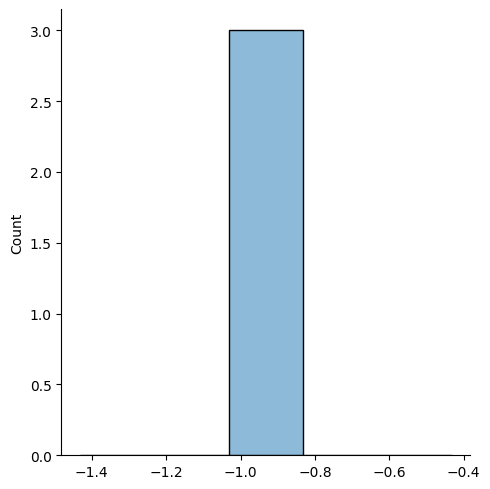

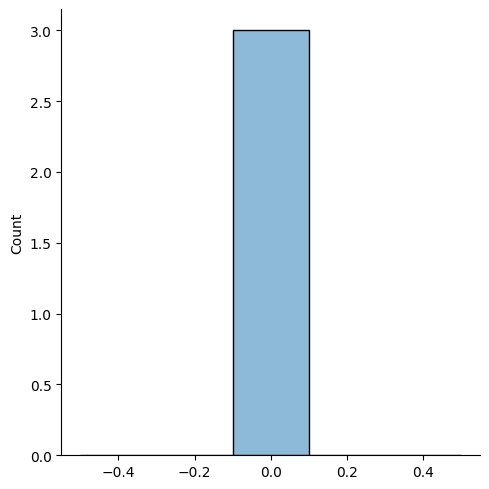

In [23]:
embeds = learn.model.center
def print_dot(ws):
    vs = [embeds(torch.tensor(word2idx[q])) for q in ws]
    similarity = torch.nn.functional.cosine_similarity(vs[0], vs[1], dim=-1)
    print(f"{ws} = {similarity.item()}")
    return similarity.item()

def on_epoch(data):
    def print_closest(q):
        q_vec = embeds(torch.tensor(word2idx[q]))
        similarity = torch.nn.functional.cosine_similarity(
            q_vec, embeds.weight, dim=-1)
        top = similarity.argsort(descending=True)[:8]
        print(', '.join([idx2word[i.item()] for i in top]))

    # for ws in [('good', 'bad'), ('great', 'good'), ('tower', 'high')]:
    #     print_dot(ws)
    # for q in ['above', 'bad', 'good', 'god', 'earth', 'tree']:
    #     print_closest(q)

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

sim_opp = []
sim_syn = []
for i in range(3):
    set_seed(i)
    model = WordEmbed(len(word2idx), 2)
    learn = fastai.learner.Learner(
        dls, model, loss_func=fastai.losses.MSELossFlat())
    learn.fit(n_epoch=3, lr=.05, cbs=Callback(after_epoch=on_epoch))
    sim_opp.append(print_dot(('good', 'bad')))
    sim_syn.append(print_dot(('terrible', 'bad')))

import seaborn as sns
sns.displot(sim_opp, bins=5, kde=True)
sns.displot(sim_syn, bins=5, kde=True)